In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os
import random
import tensorflow as tf

In [29]:
# Đọc dữ liệu
df = pd.read_csv(r"C:\Users\HI\Desktop\predict-price-ethereum\predict-price-ethereum\data\df_cleaned.csv", parse_dates=["timestamp_utc"], index_col='timestamp_utc')

In [30]:
# Sắp xếp theo thời gian (đảm bảo thứ tự)
df.sort_values("timestamp_utc", inplace=True)

df.head()

,open,high,low,close_eth,volume_eth,volume_usdt,trade_count,close_btc,fedfunds,dxy,ema_12,ema_26,macd,macd_signal,rsi_14
timestamp_utc,,,,,,,,,,,,,,,
2022-01-01 07:00:00,3711.93,3724.93,3701.00,3715.31,6541.6499,2.428604e+07,17918,47194.73,0.08,95.669998,3712.289733,3711.268607,1.021126,-2.217128,48.867772
2022-01-01 08:00:00,3715.32,3733.84,3708.60,3721.40,4013.6403,1.493429e+07,13856,47124.82,0.08,95.669998,3713.691312,3712.019080,1.672232,-1.439256,52.974584
2022-01-01 09:00:00,3721.14,3730.00,3709.38,3718.67,4515.6636,1.680313e+07,14268,47143.98,0.08,95.669998,3714.457264,3712.511741,1.945523,-0.762300,72.018873
2022-01-01 10:00:00,3718.67,3731.88,3673.46,3691.39,10412.4737,3.851047e+07,27897,46871.08,0.08,95.669998,3710.908454,3710.947168,-0.038713,-0.617583,60.614666
2022-01-01 11:00:00,3691.39,3712.19,3691.02,3693.37,4786.2173,1.771969e+07,15708,46758.87,0.08,95.669998,3708.210231,3709.645155,-1.434925,-0.781051,51.401605


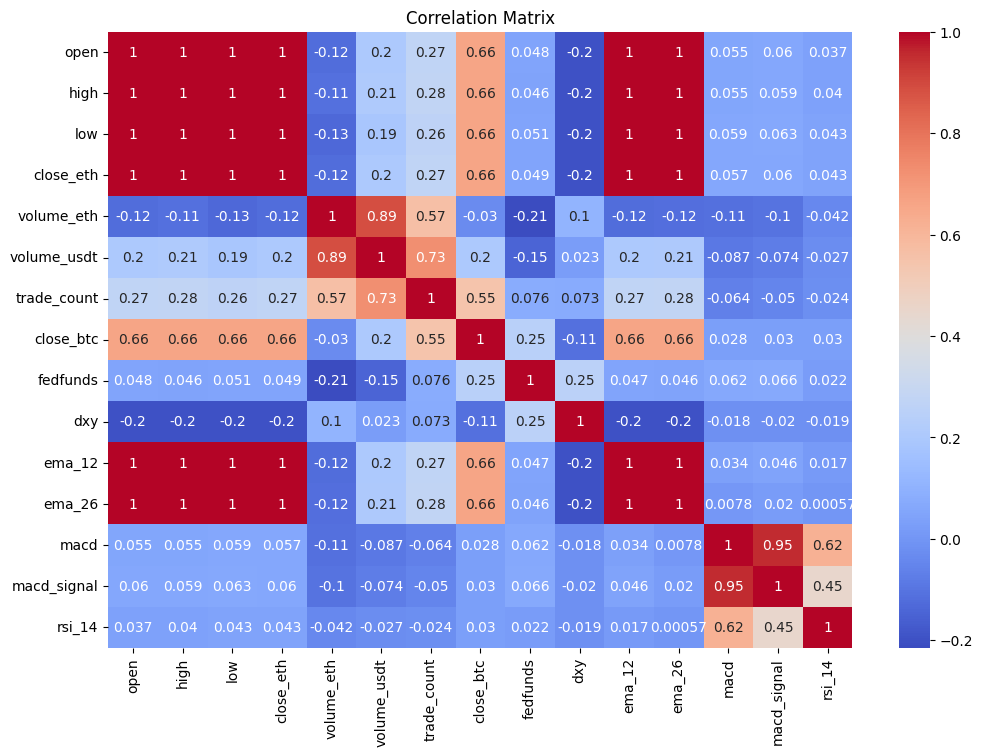

In [31]:
# Phân tích correlation để chọn feature
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm') 
plt.title('Correlation Matrix')
plt.show()

In [32]:
selected_features = ['close_eth', 'volume_eth', 'close_btc', 'dxy']
df_selected = df[selected_features].copy()
# Cố định seed cho Python, NumPy và TensorFlow
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)  # Cố định hash
random.seed(seed_value)  # Cố định Python Random
np.random.seed(seed_value)  # Cố định NumPy Random
tf.random.set_seed(seed_value)
timestamps = df.index.to_list()  # giữ lại thời gian gốc

# 2. Scale dữ liệu
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_selected)#z = x-xmin/xmax-xmin

# tạo chuỗi 
lookback = 72
steps_ahead = 24

def create_sequences_with_time(data, timestamps, lookback, steps_ahead):
    X, y, times = [], [], []
    for i in range(len(data) - lookback - steps_ahead + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+steps_ahead, 0])  
        times.append(timestamps[i+lookback:i+lookback+steps_ahead])  # lưu thời gian dự đoán
    return np.array(X), np.array(y), np.array(times)

X, y, times = create_sequences_with_time(scaled, timestamps, lookback, steps_ahead)
###

# chia train test
train_size = 0.7
val_size = 0.1

n_samples = len(X)
train_idx = int(n_samples * train_size)
val_idx = int(n_samples * (train_size + val_size))

X_train, X_val, X_test = X[:train_idx], X[train_idx:val_idx], X[val_idx:]
y_train, y_val, y_test = y[:train_idx], y[train_idx:val_idx], y[val_idx:]
times_train, times_val, times_test = times[:train_idx], times[train_idx:val_idx], times[val_idx:]

# Không reshape vì X đã ở dạng (samples, lookback, n_features)
print("Shape X_train:", X_train.shape)  
print("Shape y_train:", y_train.shape)

Shape X_train: (21399, 72, 4)
Shape y_train: (21399, 24)


In [33]:

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(lookback, X.shape[2])),
    Dense(steps_ahead)  # output nhiều bước dự đoán
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17664     
                                                                 
 dense_1 (Dense)             (None, 24)                1560      
                                                                 
Total params: 19,224
Trainable params: 19,224
Non-trainable params: 0
_________________________________________________________________


In [34]:

model.fit(X_train, y_train, epochs=10, batch_size=32,
          validation_data=(X_val, y_val), verbose=1)

preds_test_scaled = model.predict(X_test)

# Chuyển từng bước dự đoán về giá thật
preds_test_inv = []
y_test_inv = []
for i in range(len(preds_test_scaled)):
    # tạo mảng dummy để inverse_transform
    pred_dummy = np.zeros((steps_ahead, scaled.shape[1]))
    true_dummy = np.zeros((steps_ahead, scaled.shape[1]))
    pred_dummy[:, 0] = preds_test_scaled[i]
    true_dummy[:, 0] = y_test[i]
    preds_test_inv.append(scaler.inverse_transform(pred_dummy)[:, 0])
    y_test_inv.append(scaler.inverse_transform(true_dummy)[:, 0])

Epoch 1/10
669/669 [==============================] - 19s 26ms/step - loss: 0.0041 - val_loss: 7.7633e-04
Epoch 2/10
669/669 [==============================] - 18s 27ms/step - loss: 4.7760e-04 - val_loss: 8.1518e-04
Epoch 3/10
669/669 [==============================] - 17s 25ms/step - loss: 4.3607e-04 - val_loss: 6.6623e-04
Epoch 4/10
669/669 [==============================] - 23s 35ms/step - loss: 4.1381e-04 - val_loss: 5.8728e-04
Epoch 5/10
669/669 [==============================] - 28s 42ms/step - loss: 4.0910e-04 - val_loss: 9.4790e-04
Epoch 6/10
669/669 [==============================] - 23s 34ms/step - loss: 3.8179e-04 - val_loss: 7.7284e-04
Epoch 7/10
669/669 [==============================] - 22s 33ms/step - loss: 3.8566e-04 - val_loss: 5.6270e-04
Epoch 8/10
669/669 [==============================] - 19s 28ms/step - loss: 3.7714e-04 - val_loss: 0.0011
Epoch 9/10
669/669 [==============================] - 17s 26ms/step - loss: 3.7250e-04 - val_loss: 5.1055e-04
Epoch 10/10
192/19

In [35]:
for i in range(5):  
    print(f"Thực tế:   {y_test_inv[i]}")
    print(f"Dự đoán:  {preds_test_inv[i]}")
    print("-"*40)

Thực tế:   [2644.26 2641.05 2645.69 2646.03 2639.6  2631.48 2640.23 2635.98 2650.09
 2645.7  2637.41 2641.29 2642.13 2641.34 2645.   2643.31 2650.8  2648.2
 2642.49 2640.33 2639.19 2640.25 2641.79 2640.29]
Dự đoán:  [2661.2767797  2666.36986001 2678.61867074 2677.83090305 2664.86830233
 2660.12576252 2684.81838161 2675.18876094 2697.49284866 2671.9073756
 2698.1360753  2692.6476885  2689.06792642 2694.73234223 2699.78426058
 2707.34250558 2719.78650363 2698.93313763 2712.42913655 2707.54015883
 2704.54690716 2682.06185859 2707.45157527 2704.71629713]
----------------------------------------
Thực tế:   [2641.05 2645.69 2646.03 2639.6  2631.48 2640.23 2635.98 2650.09 2645.7
 2637.41 2641.29 2642.13 2641.34 2645.   2643.31 2650.8  2648.2  2642.49
 2640.33 2639.19 2640.25 2641.79 2640.29 2650.79]
Dự đoán:  [2661.59753943 2666.32983618 2678.71066865 2678.21369024 2664.88632254
 2660.33498663 2685.31384253 2675.64723301 2697.59243403 2672.67750245
 2698.76659295 2692.81043944 2689.47290693 2

In [36]:
# Ghép kết quả kèm thời gian
results_list = []
for i in range(len(preds_test_inv)):
    df_result = pd.DataFrame({
        'time': times_test[i],
        'predicted': preds_test_inv[i],
        'actual': y_test_inv[i]
    })
    results_list.append(df_result)

# Ví dụ xem kết quả của 1 dự đoán
print(results_list[0])


                  time    predicted   actual
0  2024-10-19 06:00:00  2661.276780  2644.26
1  2024-10-19 07:00:00  2666.369860  2641.05
2  2024-10-19 08:00:00  2678.618671  2645.69
3  2024-10-19 09:00:00  2677.830903  2646.03
4  2024-10-19 10:00:00  2664.868302  2639.60
5  2024-10-19 11:00:00  2660.125763  2631.48
6  2024-10-19 12:00:00  2684.818382  2640.23
7  2024-10-19 13:00:00  2675.188761  2635.98
8  2024-10-19 14:00:00  2697.492849  2650.09
9  2024-10-19 15:00:00  2671.907376  2645.70
10 2024-10-19 16:00:00  2698.136075  2637.41
11 2024-10-19 17:00:00  2692.647688  2641.29
12 2024-10-19 18:00:00  2689.067926  2642.13
13 2024-10-19 19:00:00  2694.732342  2641.34
14 2024-10-19 20:00:00  2699.784261  2645.00
15 2024-10-19 21:00:00  2707.342506  2643.31
16 2024-10-19 22:00:00  2719.786504  2650.80
17 2024-10-19 23:00:00  2698.933138  2648.20
18 2024-10-20 00:00:00  2712.429137  2642.49
19 2024-10-20 01:00:00  2707.540159  2640.33
20 2024-10-20 02:00:00  2704.546907  2639.19
21 2024-10

In [37]:
import plotly.graph_objects as go

# Chọn một dự đoán để vẽ
i = 0
df_plot = results_list[i]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_plot['time'],
    y=df_plot['actual'],
    mode='lines+markers',
    name='Actual'
))

fig.add_trace(go.Scatter(
    x=df_plot['time'],
    y=df_plot['predicted'],
    mode='lines+markers',
    name='Predicted'
))

fig.update_layout(
    title=f"Dự đoán 24 giờ tiếp theo - Mẫu test {i}",
    xaxis_title="Thời gian",
    yaxis_title="Giá ETH",
    hovermode="x unified"
)

fig.show()


In [38]:
# đánh giá 
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
import numpy as np

all_pred = np.concatenate(preds_test_inv)  
all_true = np.concatenate(y_test_inv)      

mae = mean_absolute_error(all_true, all_pred)
rmse = np.sqrt(mean_squared_error(all_true, all_pred))
r2 = r2_score(all_true, all_pred)
print("Đánh giá mô hình trên test set:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R² score: {r2:.4f}")


Đánh giá mô hình trên test set:
MAE  : 116.6903
RMSE : 145.1776
R² score: 0.9499
